In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

os.environ["http_proxy"] = "http://127.0.0.1:20171"
os.environ["https_proxy"] = "http://127.0.0.1:20171"

In [2]:
from embeddings_cpp import Tokenizer, Embedding, POOLING_METHOD_CLS, POOLING_METHOD_MEAN
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import numpy as np
import torch

def test_tokenizer_alignment(tokenizer_json, repo_name):

    tok_cpp = Tokenizer(tokenizer_json)
    auto_tok = AutoTokenizer.from_pretrained(repo_name)

    sentences = ["你好，今天天气怎么样？", "What's the weather like today?"]
    output_py = auto_tok(sentences, padding=True, truncation=True, return_tensors='pt')
    ouput_cpp = tok_cpp.encode_batch(sentences, True)

    
    auto_tok_output_input_ids = output_py["input_ids"]
    auto_tok_output_attention_mask = output_py["attention_mask"]
    for i in range(len(sentences)):
        print(f"text: {sentences[i]}")
        transformers_id = auto_tok_output_input_ids[i].numpy()
        transformers_attention_mask = auto_tok_output_attention_mask[i].numpy()


        embedings_cpp_id = np.array(ouput_cpp[i].ids)
        embedings_cpp_attention_mask = np.array(ouput_cpp[i].attention_mask)

        ids_mse = np.mean((transformers_id - embedings_cpp_id) ** 2)
        attetion_mask_mse = np.mean((transformers_attention_mask - embedings_cpp_attention_mask) ** 2)

        print(f"transformers ids: {transformers_id}")
        print(f"embeddings.cpp ids: {embedings_cpp_id}")
        print(f"ids mse: {ids_mse}")

        print(f"transformers attention mask: {transformers_attention_mask}")
        print(f"embeddings.cpp attention mask: {embedings_cpp_attention_mask}")
        print(f"attention mask mse: {attetion_mask_mse}")

def test_embedding_alignment(tokenizer_json, gguf_model, repo_name, pooling_method):
    def mean_pooling(hidden_state, mask):
        s = torch.sum(hidden_state * mask.unsqueeze(-1).float(), dim=1)
        d = mask.sum(axis=1, keepdim=True).float()
        return s / d
    def cls_pooling(hidden_state, mask):
        return hidden_state[:, 0]

    sentences = ["你好，今天天气怎么样？", "What's the weather like today?"]


    model_cpp = Embedding(tokenizer_json, gguf_model)
    print("cpp model loaded")
    res_cpp = model_cpp.batch_encode(sentences, normalize=True, pooling_method=pooling_method)

    model_sp = SentenceTransformer(repo_name)
    print(type(model_sp))
    res_sp = model_sp.encode(sentences, normalize_embeddings=True)
    print("res_sp done")

    tok_py = AutoTokenizer.from_pretrained(repo_name)
    model_py = AutoModel.from_pretrained(repo_name)
    print(type(tok_py))
    print(type(model_py))
    output_py = tok_py(sentences, padding=True, truncation=True, return_tensors='pt', max_length=8192)
    print(f"output_py: {output_py}")
    res_py = model_py(**output_py, return_dict=True)
    print(f"res_py: {res_py}")
    last_hidden_state = res_py.last_hidden_state
    print(f"last_hidden_state: {last_hidden_state}")
    pooling_fn = cls_pooling if pooling_method == POOLING_METHOD_CLS else mean_pooling
    res_py = pooling_fn(last_hidden_state, output_py['attention_mask'])
    print(f"pooling: {res_py}")
    res_py = torch.nn.functional.normalize(res_py, dim=-1)
    res_py = res_py.cpu().detach().numpy()



    return res_py, res_cpp, res_sp

/Volumes/ZT/miniconda/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
jsons = ["../models/bge-m3.tokenizer.json", "../models/bge-base-zh-v1.5.tokenizer.json", "../models/text2vec-base-multilingual.tokenizer.json"]
ggufs = ["../models/bge-m3.fp16.gguf", "../models/bge-base-zh-v1.5.fp16.gguf", "../models/text2vec-base-multilingual.fp16.gguf"]
repos = ["BAAI/bge-m3", "BAAI/bge-base-zh-v1.5", "shibing624/text2vec-base-multilingual"]
pooling_methods = [POOLING_METHOD_CLS, POOLING_METHOD_CLS, POOLING_METHOD_MEAN]

# jsons = jsons[1:]
# ggufs = ggufs[1:]
# repos = repos[1:]
# pooling_methods = pooling_methods[1:]

# jsons = jsons[:1]
# ggufs = ggufs[:1]
# repos = repos[:1]
# pooling_methods = pooling_methods[:1]

In [4]:
results = []
for i in range(len(jsons)):
    print(f"===========testing: {repos[i]}===========")
    test_tokenizer_alignment(jsons[i], repos[i])

===========testing: BAAI/bge-m3===========
text: 你好，今天天气怎么样？
transformers ids: [     0      6 124084      4   7461  70871  93985     32      2      1]
embeddings.cpp ids: [     0      6 124084      4   7461  70871  93985     32      2      1]
ids mse: 0.0
transformers attention mask: [1 1 1 1 1 1 1 1 1 0]
embeddings.cpp attention mask: [1 1 1 1 1 1 1 1 1 0]
attention mask mse: 0.0
text: What's the weather like today?
transformers ids: [    0  4865    25     7    70 92949  1884 18925    32     2]
embeddings.cpp ids: [    0  4865    25     7    70 92949  1884 18925    32     2]
ids mse: 0.0
transformers attention mask: [1 1 1 1 1 1 1 1 1 1]
embeddings.cpp attention mask: [1 1 1 1 1 1 1 1 1 1]
attention mask mse: 0.0
===========testing: BAAI/bge-base-zh-v1.5===========
text: 你好，今天天气怎么样？
transformers ids: [ 101  872 1962 8024  791 1921 1921 3698 2582  720 3416 8043  102]
embeddings.cpp ids: [ 101  872 1962 8024  791 1921 1921 3698 2582  720 3416 8043  102]
ids mse: 0.0
transformers attenti

In [6]:
results = []
for i in range(len(jsons)):
    print(f"===========testing: {repos[i]}===========") 
    res_py, res_cpp, res_sp = test_embedding_alignment(jsons[i], ggufs[i], repos[i], pooling_methods[i])
    results.append((res_py, res_cpp, res_sp))

===========testing: BAAI/bge-m3===========
cpp model loaded
compute buffer size: 0.48 MB





ggml_metal_init: allocating
ggml_metal_init: found device: Apple M4
ggml_metal_init: picking default device: Apple M4
ggml_metal_init: using embedded metal library
ggml_metal_init: GPU name:   Apple M4
ggml_metal_init: GPU family: MTLGPUFamilyApple9  (1009)
ggml_metal_init: GPU family: MTLGPUFamilyCommon3 (3003)
ggml_metal_init: GPU family: MTLGPUFamilyMetal3  (5001)
ggml_metal_init: simdgroup reduction   = true
ggml_metal_init: simdgroup matrix mul. = true
ggml_metal_init: has bfloat            = true
ggml_metal_init: use bfloat            = false
ggml_metal_init: hasUnifiedMemory      = true
ggml_metal_init: recommendedMaxWorkingSetSize  = 11453.25 MB
ggml_metal_init: loaded kernel_add                                    0x37b87b520 | th_max = 1024 | th_width =   32
ggml_metal_init: loaded kernel_add_row                                0x37b87b7e0 | th_max = 1024 | th_width =   32
ggml_metal_init: loaded kernel_sub                                    0x37b87baa0 | th_max = 1024 | th_

<class 'sentence_transformers.SentenceTransformer.SentenceTransformer'>
res_sp done
<class 'transformers.models.xlm_roberta.tokenization_xlm_roberta_fast.XLMRobertaTokenizerFast'>
<class 'transformers.models.xlm_roberta.modeling_xlm_roberta.XLMRobertaModel'>
output_py: {'input_ids': tensor([[     0,      6, 124084,      4,   7461,  70871,  93985,     32,      2,
              1],
        [     0,   4865,     25,      7,     70,  92949,   1884,  18925,     32,
              2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
res_py: BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.7921,  0.9915, -1.0649,  ..., -0.0161, -0.2259, -0.5986],
         [-0.5232,  0.2152, -0.6233,  ...,  0.5003, -0.4391, -0.7040],
         [-0.0477,  0.0192, -0.5782,  ...,  0.3989,  0.1803, -0.3553],
         ...,
         [-0.4517,  0.2428, -0.5152,  ...,  0.4386, -0.2499, -0.6772],
         [-0.4743,  0.7784, -0.0895,  ...,  0.2




ggml_metal_init: allocating
ggml_metal_init: found device: Apple M4
ggml_metal_init: picking default device: Apple M4
ggml_metal_init: using embedded metal library
ggml_metal_init: GPU name:   Apple M4
ggml_metal_init: GPU family: MTLGPUFamilyApple9  (1009)
ggml_metal_init: GPU family: MTLGPUFamilyCommon3 (3003)
ggml_metal_init: GPU family: MTLGPUFamilyMetal3  (5001)
ggml_metal_init: simdgroup reduction   = true
ggml_metal_init: simdgroup matrix mul. = true
ggml_metal_init: has bfloat            = true
ggml_metal_init: use bfloat            = false
ggml_metal_init: hasUnifiedMemory      = true
ggml_metal_init: recommendedMaxWorkingSetSize  = 11453.25 MB
ggml_metal_init: loaded kernel_add                                    0x151b872c0 | th_max = 1024 | th_width =   32
ggml_metal_init: loaded kernel_add_row                                0x151b87580 | th_max = 1024 | th_width =   32
ggml_metal_init: loaded kernel_sub                                    0x151b87840 | th_max = 1024 | th_

<class 'sentence_transformers.SentenceTransformer.SentenceTransformer'>
res_sp done
<class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>
<class 'transformers.models.bert.modeling_bert.BertModel'>
output_py: {'input_ids': tensor([[  101,   872,  1962,  8024,   791,  1921,  1921,  3698,  2582,   720,
          3416,  8043,   102],
        [  101,  9100,   112,   161,  8174,  8997, 12290,  8993, 11262,   136,
           102,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])}
res_py: BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.1561, -0.4863, -0.2972,  ..., -0.2722,  0.4573,  0.0574],
         [ 0.7076, -0.5270, -0.3692,  ..., -0.6294,  0.2975, -0.1039],
         [ 0.7070, -0.4708, -0.3683,  ..., -0.4782,  0.2893, -0.1162],
         ...,





ggml_metal_init: allocating
ggml_metal_init: found device: Apple M4
ggml_metal_init: picking default device: Apple M4
ggml_metal_init: using embedded metal library
ggml_metal_init: GPU name:   Apple M4
ggml_metal_init: GPU family: MTLGPUFamilyApple9  (1009)
ggml_metal_init: GPU family: MTLGPUFamilyCommon3 (3003)
ggml_metal_init: GPU family: MTLGPUFamilyMetal3  (5001)
ggml_metal_init: simdgroup reduction   = true
ggml_metal_init: simdgroup matrix mul. = true
ggml_metal_init: has bfloat            = true
ggml_metal_init: use bfloat            = false
ggml_metal_init: hasUnifiedMemory      = true
ggml_metal_init: recommendedMaxWorkingSetSize  = 11453.25 MB
ggml_metal_init: loaded kernel_add                                    0x151bc10e0 | th_max = 1024 | th_width =   32
ggml_metal_init: loaded kernel_add_row                                0x151bc13a0 | th_max = 1024 | th_width =   32
ggml_metal_init: loaded kernel_sub                                    0x151bc1660 | th_max = 1024 | th_

<class 'sentence_transformers.SentenceTransformer.SentenceTransformer'>
res_sp done
<class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>
<class 'transformers.models.bert.modeling_bert.BertModel'>
output_py: {'input_ids': tensor([[     0,      6, 124084,      4,   7461,  70871,  93985,     32,      2,
              1],
        [     0,   4865,     25,      7,     70,  92949,   1884,  18925,     32,
              2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
res_py: BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.2615,  0.1765, -0.0449,  ..., -0.0970, -0.2784,  0.1069],
         [ 0.2865,  0.1655,  0.0927,  ...,  0.0069, -0.3755,  0.0092],
         [ 0.1626,  0.3865,  0.0719,  ...,  0.2717, -0.1600,  0.0202],
         ...,
         [ 0.2747, -0.0258, -0.2063,  ..., -0.2296, -0.512

['BAAI/bge-m3', 'BAAI/bge-base-zh-v1.5', 'shibing624/text2vec-base-multilingual']
                                       MSE (transformers)  \
BAAI/bge-m3                                  7.910649e-09   
BAAI/bge-base-zh-v1.5                        8.878490e-09   
shibing624/text2vec-base-multilingual        9.988600e-10   

                                       MSE (sentence_transformers)  
BAAI/bge-m3                                           7.905835e-09  
BAAI/bge-base-zh-v1.5                                 8.875116e-09  
shibing624/text2vec-base-multilingual                 9.985419e-10  


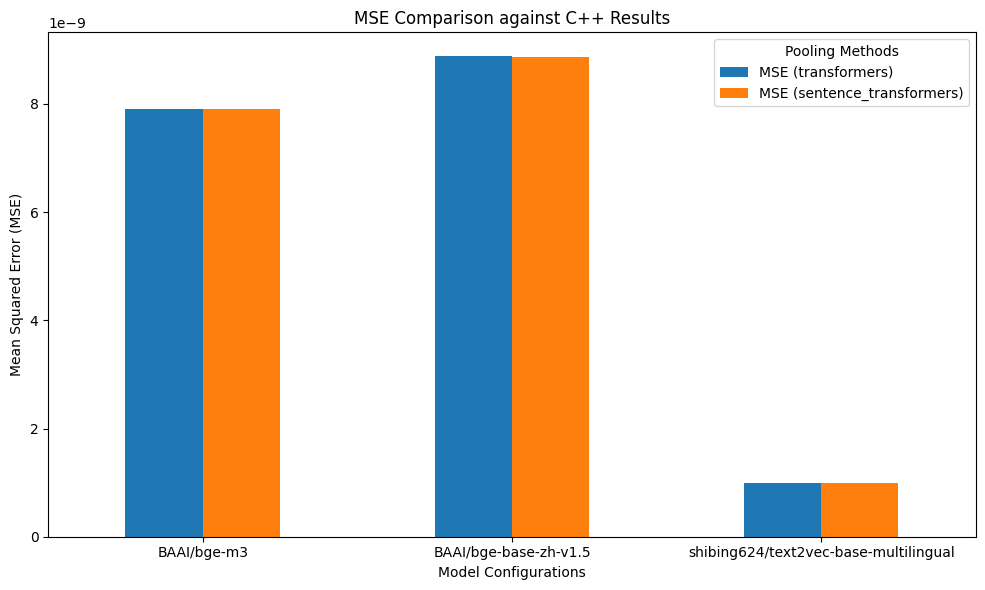

In [7]:
print(repos)
# cpp as baseline
mse_results = []
for res in results:
    res_py, res_cpp, res_sp = res
    mse_py = np.mean((res_py - res_cpp) ** 2)
    mse_sp = np.mean((res_sp - res_cpp) ** 2)
    mse_results.append((mse_py, mse_sp))

mse_df = pd.DataFrame(mse_results, columns=['MSE (transformers)', 'MSE (sentence_transformers)'], index=repos)

print(mse_df)

mse_df.plot(kind='bar', figsize=(10, 6))
plt.title('MSE Comparison against C++ Results')
plt.xlabel('Model Configurations')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.legend(title='Pooling Methods')
plt.show()